# TextCNN Model

In [3]:
# pip install torchtext

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
from wordcloud import WordCloud

In [5]:
# Load the training dataset containing text and corresponding emoji labels
train = pd.read_csv("train.csv")

# Load the mapping file that maps numeric labels to actual emoticons
mapping = pd.read_csv('Mapping.csv')

# Create a dictionary to map numeric labels to their corresponding emoticons
# 'number' column contains label IDs, 'emoticons' column contains emoji strings
emoji_map = dict(zip(mapping["number"], mapping["emoticons"]))

## Preparing Text Data for Modeling

In [8]:
# Clean Text Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @mentions
    text = re.sub(r"@\w+", "", text)
    # Remove special characters except basic punctuation
    text = re.sub(r"[^\w\s.,!?]", "", text)
    # Normalize spaces and convert to lowercase
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

# Apply text cleaning to all entries in the TEXT column
train["TEXT"] = train["TEXT"].astype(str).apply(clean_text)

# Tokenize and encode
# Initialize a basic english tokenizer
tokenizer = get_tokenizer("basic_english")

# Tokenize each cleaned tweet
train["tokens"] = train["TEXT"].apply(tokenizer)

# Build vocabulary from all unique tokens
vocab = set(token for tokens in train.tokens for token in tokens)

# Assign an index to each token
vocab_dict = {word: idx + 2 for idx, word in enumerate(vocab)}
vocab_dict["<pad>"] = 0  # padding token
vocab_dict["<unk>"] = 1  # unknown token

# Function to encode tokens into indices using vocab_dict
def encode(tokens):
    return [vocab_dict.get(t, 1) for t in tokens]

# Apply encoding to each list of tokens
train["encoded"] = train["tokens"].apply(encode)

MAX_LEN = 50
def pad(seq):
    return seq[:MAX_LEN] + [0] * (MAX_LEN - len(seq))
    
train["padded"] = train["encoded"].apply(pad)

## Building Dataset and DataLoader Objects

In [12]:
# custom dataset class for tweets
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        # Convert input sequences and labels to torch tensors
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        # total number of samples
        return len(self.labels)

    def __getitem__(self, idx):
        # single sample by index
        return self.texts[idx], self.labels[idx]

# Split data into training and validation sets (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(
    train.padded.tolist(),
    train.Label.tolist(),
    test_size=0.2
)

# dataset instances for training and validation
train_ds = TweetDataset(X_train, y_train)
val_ds = TweetDataset(X_val, y_val)

# dataLoader objects
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

## Defining and Training the TextCNN Model

In [14]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super().__init__()
        # Embedding layer maps word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Convolutional layers with multiple kernel sizes for capturing different n-gram features
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) 
            for k in kernel_sizes
        ])
        
        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        # Convert word indices to embeddings
        x = self.embedding(x)
        # Rearrange to (B, E, L)
        x = x.permute(0, 2, 1)
        # Apply convolution + ReLU activation
        x = [F.relu(conv(x)) for conv in self.convs]
        
        # Max pool over the time dimension to get fixed-size vector
        x = [F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2) for c in x]
        # Concatenate all outputs
        x = torch.cat(x, dim=1)
        
        return self.fc(self.dropout(x))

In [15]:
# Set device to GPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize TextCNN model
model = TextCNN(vocab_size=len(vocab_dict), embed_dim=100, num_classes=20).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []
# Training loop for 5 epochs
for epoch in range(5):
    model.train()
    total_loss = 0
    
    # Iterate over batches in training data
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Clear previous gradients
        optimizer.zero_grad()          
        output = model(X_batch)
        # Compute loss
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print avg loss for the epoch
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")
    train_losses.append(total_loss)

Epoch 1: Loss = 2362.0029
Epoch 2: Loss = 2199.4365
Epoch 3: Loss = 2102.2039
Epoch 4: Loss = 2003.3820
Epoch 5: Loss = 1893.4542


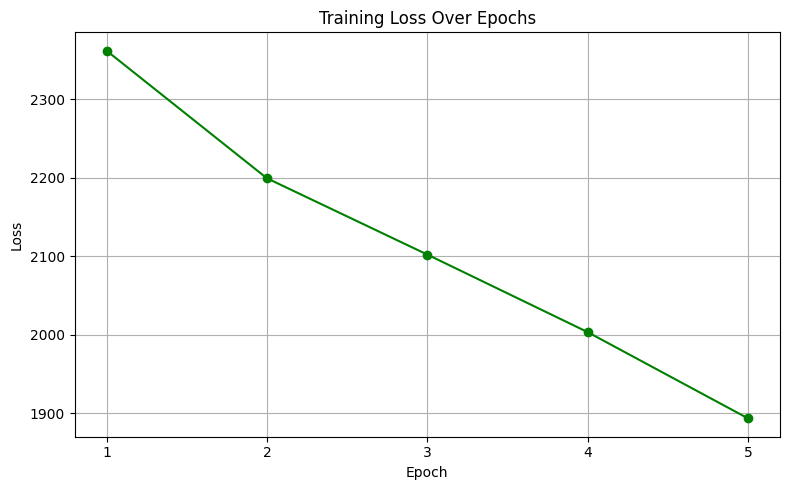

In [19]:
# Plot training loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

In [17]:
model.eval()
y_true, y_pred = [], []
# Disable gradient calculation for evaluation
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        # Get model predictions
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # Store predictions
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

# Print classification report with precision, recall, f1-score
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       308
           1       0.17      0.03      0.05       510
           2       0.22      0.17      0.19      1406
           3       0.28      0.46      0.35      1394
           4       0.00      0.00      0.00       356
           5       0.66      0.53      0.58       428
           6       0.16      0.07      0.10       482
           7       0.31      0.38      0.34       859
           8       0.20      0.00      0.00       413
           9       0.29      0.73      0.41      2990
          10       0.10      0.01      0.02       331
          11       0.55      0.41      0.47       459
          12       0.43      0.26      0.32       415
          13       0.23      0.07      0.11       627
          14       0.16      0.01      0.02       475
          15       0.18      0.03      0.05       728
          16       0.13      0.05      0.07       584
   

In [6]:
# Legend mapping label to emoji
print("Emoji Label Mapping:", ', '.join([f"{label}: {emoji}" for label, emoji in emoji_map.items()]))

Emoji Label Mapping: 0: 😜, 1: 📸, 2: 😍, 3: 😂, 4: 😉, 5: 🎄, 6: 📷, 7: 🔥, 8: 😘, 9: ❤, 10: 😁, 11: 🇺🇸, 12: ☀, 13: ✨, 14: 💙, 15: 💕, 16: 😎, 17: 😊, 18: 💜, 19: 💯


The model’s overall performance is low, with many classes having zero or very poor scores. Only a few classes, like class 9, show decent recall and F1-score, likely due to more samples. The accuracy is 29%, indicating the model struggles with most categories.

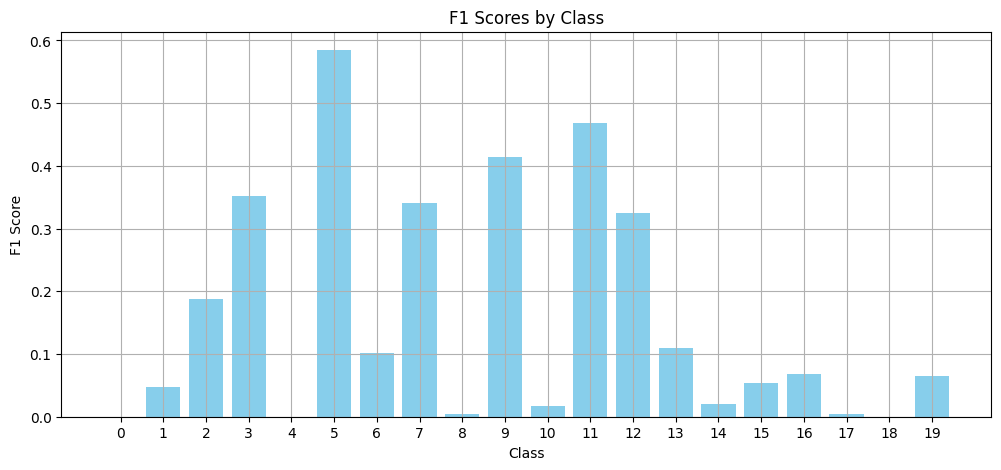

In [18]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get scores from the classification report
report = classification_report(y_true, y_pred, output_dict=True)
f1_scores = {k: v['f1-score'] for k, v in report.items() if k.isdigit()}

plt.figure(figsize=(12, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.title("F1 Scores by Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [1]:
def predict_emoji(model, text, vocab_dict, max_len=30):
    model.eval()
    # Tokenize text by splitting on spaces
    tokens = text.lower().split()
    indices = [vocab_dict.get(token, vocab_dict['<unk>']) for token in tokens]
    if len(indices) < max_len:
        indices += [vocab_dict['<pad>']] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    # Convert to tensor and move to model's device
    input_tensor = torch.tensor([indices]).to(next(model.parameters()).device)
    
    with torch.no_grad():
        output = model(input_tensor)
        # Get probabilities
        probs = F.softmax(output, dim=1).cpu().numpy()[0]
    
    return probs

# Load your test dataset
test_data = pd.read_csv('Test.csv')
test_tweets = test_data['TEXT'].tolist()[:5] # Select first 5 tweets

# Predict and visualize top 3 emojis for each tweet
for tweet in test_tweets:
    pred_probs = predict_emoji(model, tweet, vocab_dict)
    top_indices = pred_probs.argsort()[-3:][::-1]
    top_probs = [pred_probs[i] for i in top_indices]

    # Print top predicted emojis with confidence scores
    print("Top predicted emojis and confidence:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {emoji_map[idx]} — {top_probs[i]:.2f}")
    print("\n")

Thought this was cool...#Repost (get_repost)・・・Colorview. by shay_images…
Top predicted emojis and confidence: 
 1. 😂 — 0.24 
 2. 📷 — 0.22 
 3. 💯 — 0.13

Happy 4th! Corte madera parade. #everytownusa #merica @ Perry's on…
Top predicted emojis and confidence: 
 1. 😎 — 0.18 
 2. 😜 — 0.15 
 3. 📷 — 0.13

Luv. Or at least something close to it. @ Union Hill, Richmond, Virginia
Top predicted emojis and confidence: 
 1.  😂 — 0.34 
 2. 😎 — 0.16 
 3. 📷 — 0.10


## Conculsion
The TextCNN model captures short, punchy phrases well and tends to favor expressive emojis like 😂, 😎, and 📷. It performs especially well on tweets with clear visual or emotional cues, such as "Happy 4th!" or photo-related posts. For example, it confidently predicts 📷 for a tweet referencing a parade, and 😂 for casual, humorous text. While the top predictions often overlap, suggesting some class ambiguity, the results generally align with the tone of the tweet. The model shows potential for fast, reasonably accurate emoji prediction, especially on concise and expressive social media content.